## Automatizované hľadanie parametrov modelu 

V minulom cvičení sme si ukázali ako funguje ladenie modelu pomocou nastavovania hodnôt jeho parametrov. Tento proces môže prebiehať aj automatizovane - generovaním množstva modelov s rôznymi parametrami a ich vyhodnocovaním. Cieľom tejto úlohy je demonštrovať ako takýmto spôsobom hľadať najvhodnejšie paramertre klasifikačného modelu. V nasledujúcej úlohe demonštrujeme, ako takýmto spôsobom hľadať optimálne parametre pre model k-NN.

Rovnako ako v predchádzajúcej úlohe budeme pracovať s datasetom Titanic, ktorý sme predspracovali na cvičení č. 7. Pre účely ladenia parametrov ho predspracujeme rovnakým spôsobom (použitím rovnakých transformácií) ako v predošlom cvičení.

Najprv teda naimportujeme všetky potrebné knižnice.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Načítame teda do dátového rámca `titanic` predspracované dáta z datasetu Titanic, z cvičenia č. 7. Nachádzajú sa v súbore `../data/titanic-processed.csv`.

In [2]:
titanic = pd.read_csv("../data/titanic-processed.csv")
titanic.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family,has_family,fare_ordinal,title,title_short,age_ordinal,deck
0,1,1,female,29.00,0,0,24160,211.3375,B5,Southampton,0,False,most expensive,Miss,Miss,adult,B
1,1,1,male,0.92,1,2,113781,151.5500,C22 C26,Southampton,3,True,most expensive,Master,rare title,child,C
2,1,0,female,2.00,1,2,113781,151.5500,C22 C26,Southampton,3,True,most expensive,Miss,Miss,child,C
3,1,0,male,30.00,1,2,113781,151.5500,C22 C26,Southampton,3,True,most expensive,Mr,Mr,adult,C
4,1,0,female,25.00,1,2,113781,151.5500,C22 C26,Southampton,3,True,most expensive,Mrs,Mrs,adult,C


Keďže budeme vytvárať rovnaký model (k-NN)ako v predošlých úlohách, niektoré z atribútov nepoužijeme (tie, ktoré obsahujú priveľa chýbajúcich hodnôt, resp. tie, ktoré obsahujú príliš veľké množstvo kategorických hodnôt), iné transformujeme pomocou One Hot Encoderu, alebo priradením číselných indexov.

In [3]:
titanic = titanic.drop(columns=['cabin','deck','ticket','title'])
titanic['sex'] = titanic['sex'].map({"male": 0, "female": 1})
titanic['has_family'] = titanic['has_family'].map({False: 0, True: 1})
titanic['fare_ordinal'] = titanic['fare_ordinal'].map({"normal": 0, "more expensive": 1, "most expensive": 2})
titanic['age_ordinal'] = titanic['age_ordinal'].map({"child": 0, "young": 1, "adult": 2, "old": 3}) 
titanic = pd.get_dummies(titanic, columns=['embarked', 'title_short'])

In [4]:
titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,family,has_family,fare_ordinal,age_ordinal,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton,title_short_Miss,title_short_Mr,title_short_Mrs,title_short_rare title
0,1,1,1,29.00,0,0,211.3375,0,0,2,2,0,0,1,1,0,0,0
1,1,1,0,0.92,1,2,151.5500,3,1,2,0,0,0,1,0,0,0,1
2,1,0,1,2.00,1,2,151.5500,3,1,2,0,0,0,1,1,0,0,0
3,1,0,0,30.00,1,2,151.5500,3,1,2,2,0,0,1,0,1,0,0
4,1,0,1,25.00,1,2,151.5500,3,1,2,2,0,0,1,0,0,1,0


Keďže vytváram model k-NN, je vhodné dáta predspracovať aj normalizáciou. Použijeme teda znova `MinMaxScaler`, aby sme atribúty naškálovali na jednotnú mierku. 

In [5]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler() 
titanic = pd.DataFrame(scaler.fit_transform(titanic), index=titanic.index, columns=titanic.columns)
titanic.head() 

,pclass,survived,sex,age,sibsp,parch,fare,family,has_family,fare_ordinal,age_ordinal,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton,title_short_Miss,title_short_Mr,title_short_Mrs,title_short_rare title
0,0.0,1.0,1.0,0.361142,0.000,0.000000,0.412503,0.0,0.0,1.0,0.666667,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.009395,0.125,0.222222,0.295806,0.3,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.022924,0.125,0.222222,0.295806,0.3,1.0,1.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.373669,0.125,0.222222,0.295806,0.3,1.0,1.0,0.666667,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.311036,0.125,0.222222,0.295806,0.3,1.0,1.0,0.666667,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Na takto predspracovanej množine už môžeme vyskúšať natrénovať klasifikačný model. Podobne ako v predchádzajúcom cvičení najprv rozdelíme dáta do matice príznakov a vektora hodnôt cieľového atribútu.
Cieľovým atribútom v tejto úlohe je `survived` (vyjadruje, či daný pasažier nehodu prežil alebo nie). Cieľový atribút teda bude tvoriť vektor hodnôt `y` a zostávajúce stĺpce maticu príznakov `X`.

In [6]:
X_titanic = titanic.drop('survived', axis=1) # vytvoríme maticu príznakov - použijeme všetky stĺpce okrem cieľového atribútu a uložíme do X_titanic
y_titanic = titanic['survived'] # vytvoríme vektor hodnôt cieľového atribútu ako stĺpec 'survived'

print(X_titanic.shape) # pre kontrolu môžeme vypísať rozmery matice hodnôt a vektora cieľového atribútu
print(y_titanic.shape)

(1309, 17)
(1309,)


Teraz rozdelíme dáta do trénovacej a testovacej množiny. Na rozdelenie dát na trénovacie a testovacie použijeme funkciu `train_test_split()`, tesovacia množina bude v pomere 30/70 k trénovacej.

In [7]:
from sklearn.model_selection import train_test_split # importujeme funkciu train_test_split()

X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=1) # rozdelíme dataset do trénovacej a testovacej časti, tak že testovacia bude 30% z celkového datasetu

Vytvoríme objekt k-NN modelu. Bez špecifických parametrov - tie tentoraz budeme hľadať pomocou funkcie GridSearch. 

In [8]:
from sklearn.neighbors import KNeighborsClassifier # importujeme knižnicu pre K-NN

knn = KNeighborsClassifier() # inicializujeme klasifikátor

### GridSearch pre hľadanie optimálnych nastavení algoritmov

Pomocou funkcie `GridSearchCV` môžeme automatizovať hľadanie optimálnych parametrov algoritmov. Grid Search je prístup, ktorý automaticky vytvorí množinu modelov s rôznymi nastaveniami, ktoré validuje použitím krížovej validácie. 

#### Nastavenie parametrov Grid Search

Funkcii Grid Search v Scikit-learn špecifikujeme niekoľko vstupných parametrov, ktoré potom definujú, akým spôsobom sa automatizované testovanie parametrov modelu uskutoční. 

V príklade nižšie vyskúšame nájsť pomocou Grid Search optimálnu hodnotu parmetra `k` pre model k-NN. Najprv definujeme rozsah hodnôt parametra `k`, ktoré chceme testovať. 

In [9]:
from sklearn.model_selection import GridSearchCV # importujeme potrebné knižnice

# definujeme hodnoty parametrov, ktoré sa budú prehľadávať
# pre parameter k vygenerujeme rozsah 1 až 50

k_range = list(range(1, 50))
print(k_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


Vytvoríme pole parametrov modelu. Tu si musíme dať pozor - pole pre jednotlivé parametre musíme vytvoriť tak, aby názvy parametrov zodpovedali názvom parametrov jednotlivých modelov. 

V tomto príklade sme vygenerovali pole celých čísel, ktoré chceme použiť ako rôzne hodnoty pre testovanie parametra `k`. V k-NN modeli sa tento parameter nazýva `n_neighbors` (pri nastavovaní parametra klasifikátora k-NN sme modely vytvárali ako napr. `KNeighborsClassifier(n_neighbors = 3)`), preto namapujeme do premennej, ktorá bude uchovávať kolekciu parametrov(`param_grids`) pole týchto hodnôt, ktoré priradíme parametru `n_neighbors`.

In [10]:
# vytvoríme tzv. parameter grid: namapujeme vygenerované hodnoty do poľa parametrov
# v tomto prípade vytvoríme parameter n_neighbors, ktorému priradíme pole jeho skúmaných hodnôt

param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}


Teraz, keď máme nastavené pole parametrov, ktoré chceme preskúmať, spustíme Grid Search. `GridSearchCV` má nasledovné parametre:
* `estimator` - model, ktorý chceme trénovať (v našom prípade `knn`)
* `param_grid` - kolekcia parametrov modelu a zoznamov ich hodnôt - pozor, pole parametrov musí byť kompatibilné s parametrami modelu!
* `cv` - faktor kížovej validácie
* `scoring` - metrika používaná na vyhodnotenie v krížovej validácii modelov (napr. `accuracy`, `precision`, `recall` atď.)

In [11]:
# aplikujeme Grid Search - nastavíme parametre:
# model - knn
# pole parametrov - param_grid
# budeme používať 5-násobnú krížovú validáciu 
# na vyhodnotenie použijeme metriku accuracy

grid = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy') # nastavíme parametre Grid Searchu
grid.fit(X_train, y_train) # aplikujeme Grid Search na trénovacích dátach

C:\Users\Inu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

#### Vyhodnotenie výsledkov Grid Search

Teraz máme natrénovanú množinu klasifikátorov s rôznymi nastaveniami a cez rôzne funkcie objektu `grid` sa môžeme pozrieť na konrétne výsledky modelov s rôznymi hodnotami vstupného parametra `k`.

Pomocou `best_params_` sa môžeme pozrieť, ktorý model dosiahol najlepšie výsledky. 

In [12]:
print("Najlepšie parametre sú:")
print()
print(grid.best_params_)
print()
print(grid.best_score_)

Najlepšie parametre sú:

{'n_neighbors': 16}

0.8122270742358079


Pomocou `cv_results_` vieme získať rôzne metriky:

* `mean_test_score` - priemerné skóre (definované ako parameter Grid Search-u)  
* `std_test_score` - štandardná odchýlka skóre     
* `rank_test_score` - poradie v skóre na testovacích dátach    
* `mean_train_score` - priemerné skóre (na trénovacích podmnožinách)   
* `std_train_score` - štandardná odchýkla skóre na trénovacích dátach   
* `mean_fit_time` - priemerný čas trénovania modelu     
* `std_fit_time` - štandardná odchýlka času trénovania modelu       
* `mean_score_time` - priemerný čas vyhodnocovania neznámych príkladov   
* `std_score_time` - štandardná odchýlka času vyhodnocovania    
* `params` - parametre modelov

Môžeme sa teda pozrieť, aké rôzne metriky a informácie objekt `cv_results_` uchováva:

In [13]:
sorted(grid.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

Môžeme sa teda pozrieť na konkrétne výsledky konkrétnych modelov.

In [14]:
print(grid.cv_results_["mean_test_score"][24]) # výsledky pre konkrétnu metriku a pre konkrétny model

0.7947598253275109


Môžeme sa samozrejme pozrieť na to, aké výsledky dosiahli všetky modely naraz. Vypíšeme priemerné skóre krížovej validácie, jeho štandardnú odchýlku a parametre daného modelu. Aby bol výpis lepšie čitateľný, je potrebné výpis rozumne naformátovať. 

In [15]:
# môžeme sa pozrieť na kompletné výsledky

print("Jednotlivé skóre pre jednotlivé hodnoty parametra k:")
print()

means = grid.cv_results_['mean_test_score'] # do premennej means priradíme výsledky priemerov testovacieho skóre
stds = grid.cv_results_['std_test_score'] # do premennej stds priradíme zoznam štandardných odchýliek
params = grid.cv_results_['params']

for mean, std, params in zip(means, stds, params): # pre všetky záznamy vypíšeme naformátovaný výstup - zip mapuje rovnaké indexy viacerých kontajnerov/polí aby mohli byť používané ako jedna entita
    print("%0.3f (+/-%0.03f) pre hodnotu %s" % (mean, std, params)) # naformátujeme výpis
print()

Jednotlivé skóre pre jednotlivé hodnoty parametra k:

0.755 (+/-0.025) pre hodnotu {'n_neighbors': 1}
0.778 (+/-0.016) pre hodnotu {'n_neighbors': 2}
0.789 (+/-0.020) pre hodnotu {'n_neighbors': 3}
0.796 (+/-0.026) pre hodnotu {'n_neighbors': 4}
0.793 (+/-0.028) pre hodnotu {'n_neighbors': 5}
0.798 (+/-0.012) pre hodnotu {'n_neighbors': 6}
0.785 (+/-0.021) pre hodnotu {'n_neighbors': 7}
0.791 (+/-0.021) pre hodnotu {'n_neighbors': 8}
0.793 (+/-0.027) pre hodnotu {'n_neighbors': 9}
0.801 (+/-0.036) pre hodnotu {'n_neighbors': 10}
0.802 (+/-0.028) pre hodnotu {'n_neighbors': 11}
0.810 (+/-0.033) pre hodnotu {'n_neighbors': 12}
0.800 (+/-0.030) pre hodnotu {'n_neighbors': 13}
0.810 (+/-0.032) pre hodnotu {'n_neighbors': 14}
0.801 (+/-0.028) pre hodnotu {'n_neighbors': 15}
0.812 (+/-0.035) pre hodnotu {'n_neighbors': 16}
0.802 (+/-0.041) pre hodnotu {'n_neighbors': 17}
0.802 (+/-0.044) pre hodnotu {'n_neighbors': 18}
0.802 (+/-0.042) pre hodnotu {'n_neighbors': 19}
0.802 (+/-0.042) pre hod

Môžeme sa (pomocou prístupu k jednotlivým prvkom výsledkov) pozrieť aj na konkrétne výsledky zvoleného modelu. Môžeme aj preskúmať jednotlivé čiastkové výsledky z krížovej validácie daného modelu. Po špecifikácii parametra teda môžeme špecifikovať aj index, pomocou ktorého pristúpime ku konkrétnemu modelu.

In [16]:
# môžeme preskúmať jednotlivé modely a ich konkrétne výsledky

print('Parameter k pre model 0:')
print(grid.cv_results_["params"][0])

# skóre modelu s indexom 0 (k=1) pre jednotlivé splity krížovej validácie
print()
print('CV skóre pre model 0:')
print(grid.cv_results_["split0_test_score"][0])
print(grid.cv_results_["split1_test_score"][0])
print(grid.cv_results_["split2_test_score"][0])
print(grid.cv_results_["split3_test_score"][0])
print(grid.cv_results_["split4_test_score"][0])

# Priemerné skóre modelu s indexom 0
print()
print('Priemerné skóre pre model 0')
print(grid.cv_results_["mean_test_score"][0])

Parameter k pre model 0:
{'n_neighbors': 1}

CV skóre pre model 0:
0.75
0.7989130434782609
0.7336956521739131
0.7637362637362637
0.7307692307692307

Priemerné skóre pre model 0
0.7554585152838428


#### Vizualizácia závislosti hodnoty parametra k na skóre

Pre lepšie pochodpenie závislosti jedného parametra od výsledného skóre modelu môžeme vizualizovať. Vykreslenie závislosti presnosti a hodnoty parametra `k` a metriky Accuracy na testovacej množine potom v tomto prípade veľmi jednoducho vizualizujeme pomocou matplotlib. 

Text(0, 0.5, 'Uspesnost')

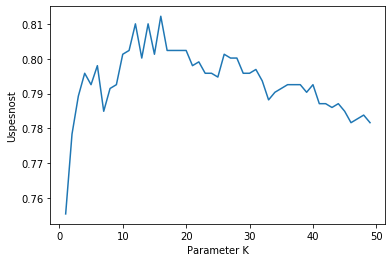

In [17]:
# pomocou matplotlib vykreslíme závislosť hondôt parametra k a skóre teda medzi týmito dvoma veličinami:

# YOUR CODE HERE
plt.plot(k_range, means)
plt.xlabel('Parameter K')
plt.ylabel('Uspesnost')

### Simultánne hľadanie viacerých parametrov

Metóde Grid Search vieme špecifikovať viacero parametrov súčasne. Algoritmus tak bude hľadať všetky kombinácie definovaných parametrov. 

Skúsime hľadať kombináciu aj ostatných parametrov. Pre algoritmus k-NN vieme nastavovať ešte parametre špecifikujúce váhovanie vzdialenosti alebo použitú metriku. Vytvoríme teda ďalšie zoznam hodnôt parametra `weights` a zoznam, ktorý zodpovedá hodnotám parametra `metric`.

In [18]:
# vytvorte zoznamy parametrov pre váhy a metriky algoritmu k-NN

weights_range = ["uniform", "distance"]
metric_range = ["euclidean", "manhattan"]

Oba z týchto zoznamov potom pridáme spolu so zoznamom `k_range` do zoznamu parametrov. 

Parameter algoritmu kNN, ktorý špecifikuje váhovanie sa nazýva `weights` a parameter definujúci metriky sa nazýva `metric`. Priradíme im zoznamy ich hodnôt, ktoré chceme preskúmať. Do kolekcie `param_grid` teda vložíme polia hodnôt pre jednotlivé parametre.

In [19]:
# vytvorte pole parametrov pre definované parametre a ich rozsahy

param_grid = dict(n_neighbors=k_range, weights=weights_range, metric=metric_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}


Teraz rovnakým spôsobom spustíme Grid Search - špecifikujeme model, zoznam parametrov, parameter nastavenia krížovej validácie a definujeme metriku vyhodnocovania. 

In [20]:
# nastavme parametre Grid Searchu

grid = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy') 
grid.fit(X_train, y_train) # naučíme Grid Search na trénovacích dátach

C:\Users\Inu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

Rovnakým spôsobom môžeme opäť pristúpiť k výsledkom. 

Pozrime sa na najlepší z modelov a jeho výsledok a potom rovnakým spôsobom ako v predošlej úlohe vypíšeme kompletné výsledky.

In [21]:
print("Najlepšie parametre sú:")
print()
print(grid.best_params_)
print()
print(grid.best_score_)

Najlepšie parametre sú:

{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'}

0.8144104803493449


In [27]:
# Vypíšeme všetky výsledky

means = grid.cv_results_['mean_test_score']
for mean, params in zip(means, grid.cv_results_['params']):
    print(mean,'pre hodnotu',params)
    #print("%0.3f pre hodnotu %s" %(mean, params))
print()

0.7554585152838428 pre hodnotu {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.7554585152838428 pre hodnotu {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.7783842794759825 pre hodnotu {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.7543668122270742 pre hodnotu {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
0.7893013100436681 pre hodnotu {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.7663755458515283 pre hodnotu {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.7958515283842795 pre hodnotu {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
0.7663755458515283 pre hodnotu {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
0.7925764192139738 pre hodnotu {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.7762008733624454 pre hodnotu {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.7980349344978166 pre hodnotu {'metric': 'eu

Použitím `GridSearchCV` sme natrénovali modely s rôznymi parametrami na trénovacej množine. Zároveň, použitím krížovej validácie sme ich na trénovacej množine aj validovali. Identifikovali sme tak najlepšie parametre modelu. Ak chceme model otestovať na testovacej množine, aby sme tak overili jeho kvalitu alebo aby sme model mohli použiť pre predikciu nových, neoznačených príkladov, musíme model s identifikovanými parametrami opäť natrénovať. Potom ho môžeme otestovať na testovacej množine a vypísať kontigenčnú tabuľku klasifikácie. 

### Úloha 12.1

Natrénujte model s najlepšími parametrami na trénovacej množine a otestujte na testovacej. Vypíšte kontigenčnú tabuľku výsledkov (confusion matrix). 

In [22]:
from sklearn.neighbors import KNeighborsClassifier 
model = KNeighborsClassifier(n_neighbors=20, weights='uniform',metric='manhattan')             

model.fit(X_train, y_train)                 

y_model = model.predict(X_test)

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_model)
print(cm)

[[215  21]
 [ 60  97]]
